In [2]:
#!/opt/miniconda3/envs/thesis/bin python

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'


import os
import sys
from subprocess import Popen, PIPE, CalledProcessError
# from io import StringIO
import time
from gvar import gvar
from UWerr import UWerr
from ruamel.yaml import YAML

from IPython.display import HTML, display
from ipywidgets.widgets import Output

In [3]:
class Observable(object):
    def __init__(self,label,func,scale = 'linear'):
        self.label = label
        self.func = func
        self.scale = scale

    def __call__(self, data):
        average = self.func(data)
        return gvar(average, self.jackknife(data, average))

    def jackknife(self, data, average=None, tau=0.5):
        cumsum = 0
        if average is None: 
            average = self.func(data)
        for i in data.index:
            cumsum += ( self.func(data.drop(i)) - average )**2
        return np.sqrt(2 * tau * cumsum)

global_observables = dict(
    action          =   Observable(r"S", 
                                   lambda data: np.mean(data['S']/(data['beta']*L**2)) ),
    internal_energy =   Observable(r"E", 
                                   lambda data: np.mean(data['S']/(0.5*data['beta']*L**2)) ),
    chi_m           =   Observable(r"\chi_m", 
                                   lambda data: np.mean(data['chi_m'])/L**2, scale='log'),
    delta_m         =   Observable(r"\delta_m",
                            lambda data,beta:
                                2 * 10**5 * beta**4 * np.exp(-4*np.pi*beta) * np.mean(data['chi_m'])/(L**2),
                            scale = 'log'),
    Q               =   Observable(r"Q", 
                                   lambda data: np.mean(data['Q'])),
    chi_t           =   Observable(r"\chi_t", 
                                   lambda data: np.mean(data['Q']**2/L**2),scale='log')
)

def magnetization(phi):
    return np.mean(np.abs(phi))

def binder_cumulant(phi):
    return 1 - np.mean(phi**4) / (3 * np.mean(phi**2)**2)

def susceptibility(phi):
    return np.mean(phi**2) - np.mean(np.abs(phi))**2

def action(phi,S,beta):
    return np.mean(S)/(beta*L**2)

def internal_energy(phi,S,beta):
    return np.mean(S)/(0.5*beta*L**2)

In [4]:
cores = 1
actions = []
phibars = []
betas = [0.5, 1.0, 1.5]
taus = np.arange(0,3,0.1) #[0.1, 0.5, 1.0, 5.0]
output_file = "outputs/gf/data.csv"
def o_filename(beta): return f"outputs/gf/data_{beta}.csv"
def i_filename(beta): return f"inputs/gf/params_{beta}.yml"
o_filenames = [o_filename(beta) for beta in betas]
L = 100

measurements = 100
thermalization = 1000
record_rate = 50
def print_stats():
    print(f"{measurements} measurements every {record_rate} sweeps, {thermalization} sweep thermalization.")

In [35]:
yaml = YAML()
yaml.indent(sequence=4, offset=2)


processes = []
for beta in betas:
    yaml_data = {
            'beta': beta,
            'L':    L,
            'measurements': measurements,
            'thermalization': thermalization,
            'record_rate': record_rate,
            'taus': taus.tolist() if type(taus) is np.ndarray else taus
            }
    with open(i_filename(beta), 'w') as yaml_file:
        yaml.dump(yaml_data, yaml_file)

    cmd = ["mpiexec",
            "-n", str(cores),
            "cpp_code/bin/sweep",
            "-i", i_filename(beta),
            "-o", o_filename(beta)]
    processes.append( Popen(cmd, stdout=PIPE, stderr=PIPE, bufsize=1, universal_newlines=True) )

In [36]:
progress = Output(layout={'border': '1px solid black'})
display(progress)
delay = 0.1
started = [False for _ in processes]
finished = [False for _ in processes]
last_print = time.time()
while not all(finished):
    for i,p in enumerate(processes):
        line = p.stdout.readline()
        if (time.time() - last_print) > delay:
            if i==0:
                progress.clear_output()
            if "Working" in line:
                if not started[i]:
                    started[i] = True
                with progress:
                    print(f" {i}> " + line)
            else:
                if started[i]:
                    finished[i] = True
                with progress:
                    print(f" {i}| " + line)
            if i==len(processes)-1: last_print = time.time()
                
# # Combine the files
with open(output_file, 'w') as sumfile:
    needs_header = True
    for ofilename in o_filenames:
        with open(ofilename,'r') as ofile:
            if needs_header:
                sumfile.write(next(ofile))
                needs_header = False
            else:
                next(ofile)
            sumfile.write(ofile.read())
        os.remove(ofilename)
        
print_stats()

Output(layout=Layout(border='1px solid black'))

100 measurements every 50 sweeps, 1000 sweep thermalization.


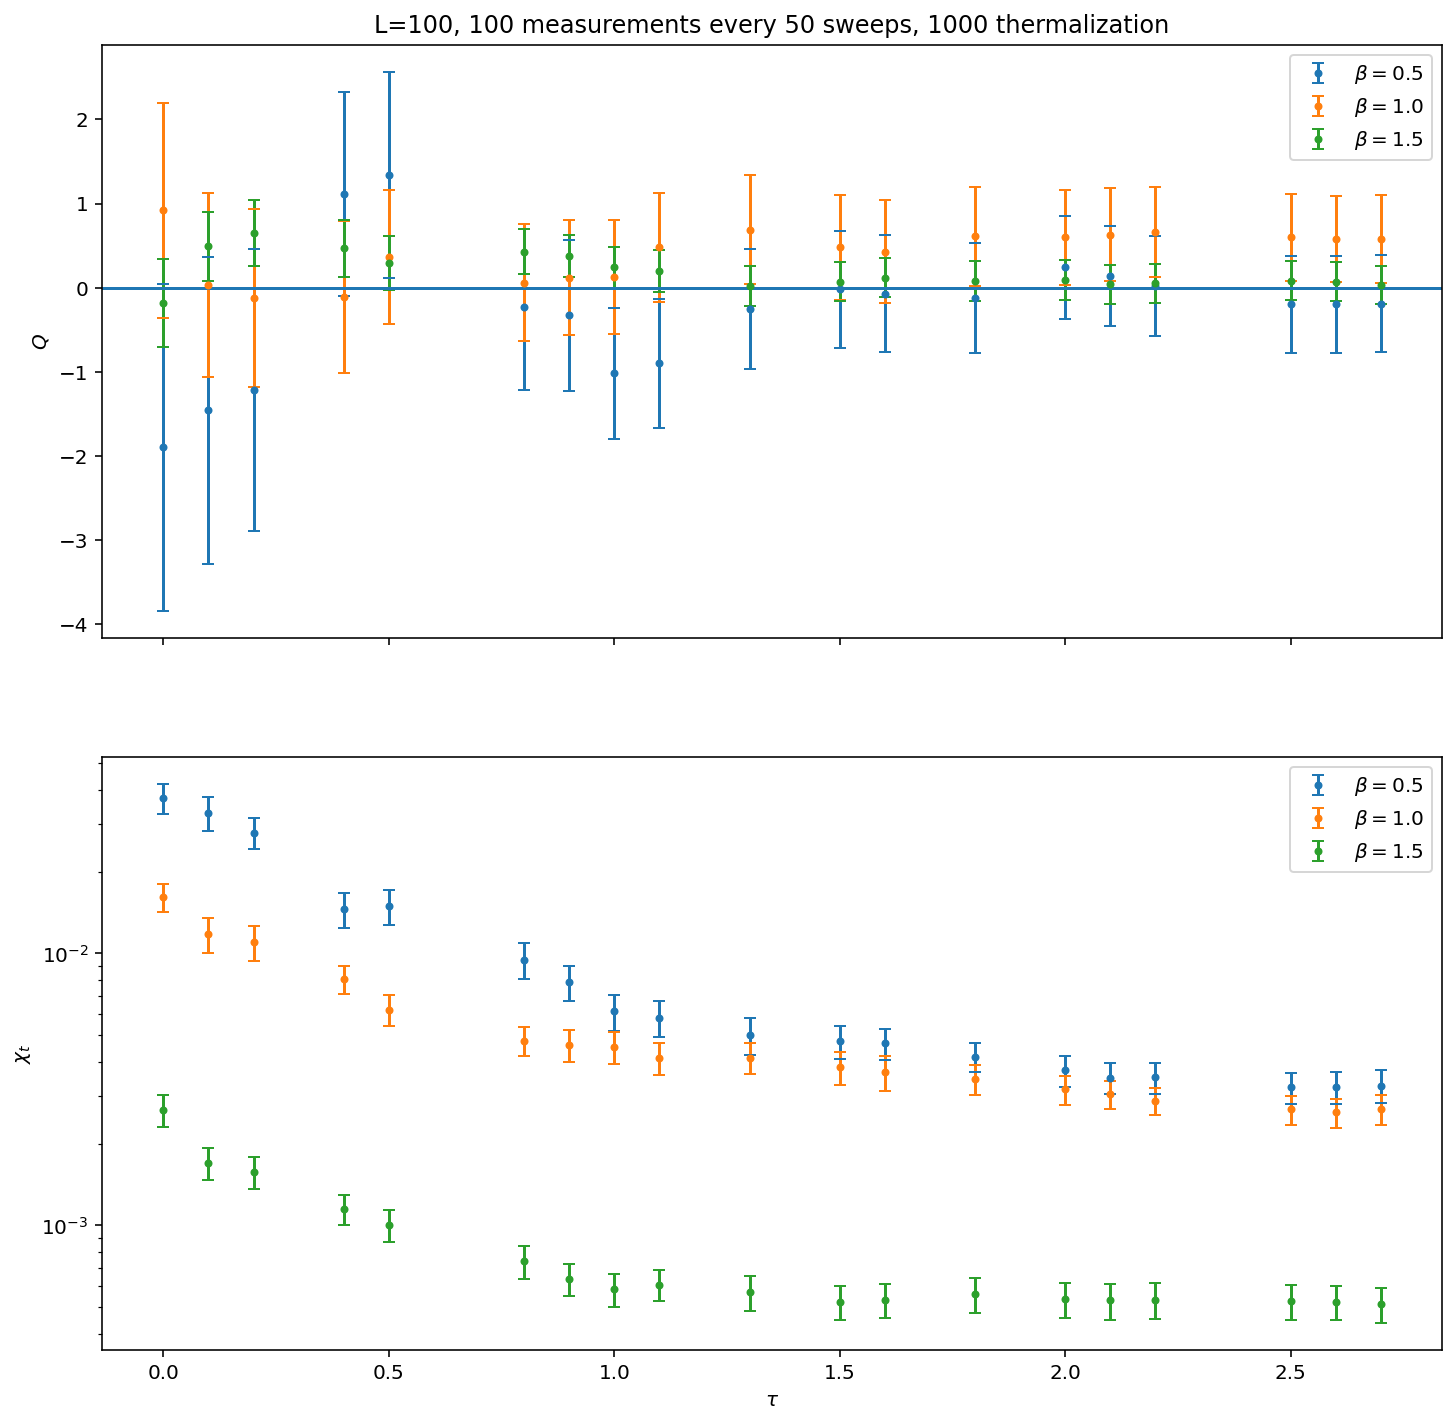

In [37]:
data = pd.read_csv(output_file)

observ_names = ['Q','chi_t']
observ_objs = [global_observables[o] for o in observ_names]

fig,axes = plt.subplots(len(observ_names),1,figsize=(12,6*len(observ_names)), sharex=True, squeeze=False)
axes = [ax for row in axes for ax in row] # flatten axes

axes[0].set_title(f"L={L}, {measurements} measurements every {record_rate} sweeps, {thermalization} thermalization")
axes[-1].set_xlabel(r"$\tau$")

for ax, O in zip(axes, observ_objs):
    for beta in betas:
        d = []
        for tau in taus:
            trial = data[(data['tau'] == tau) & (data['beta'] == beta)]
            d.append(O(trial))

        ax.errorbar(taus, [x.mean for x in d], yerr=[x.sdev for x in d], fmt='.', label=f"$\\beta={beta:.1f}$", capsize=3.)
        ax.legend()

    ax.set_ylabel('$'+O.label+'$')
    ax.set_yscale(O.scale)
    #ax.set_xlim((0.4, 2.6))
    
axes[0].axhline(0)

plt.show()

1000 measurements every 1 sweeps, 1000 sweep thermalization.


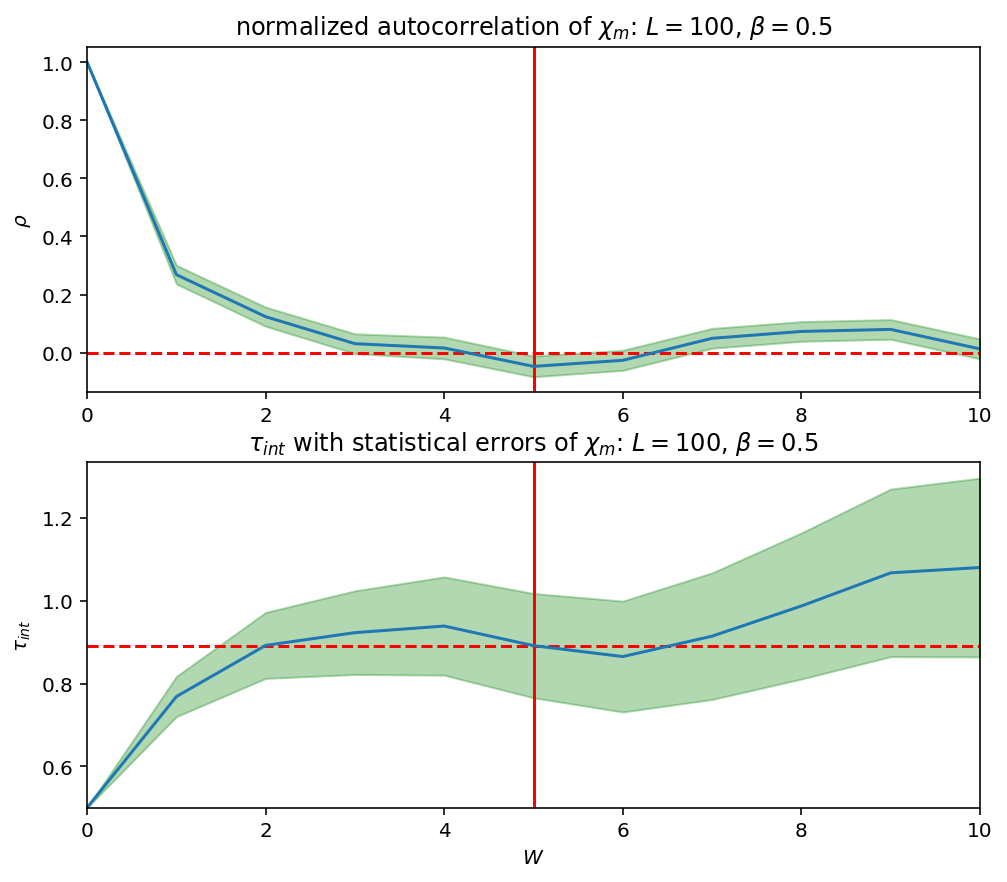

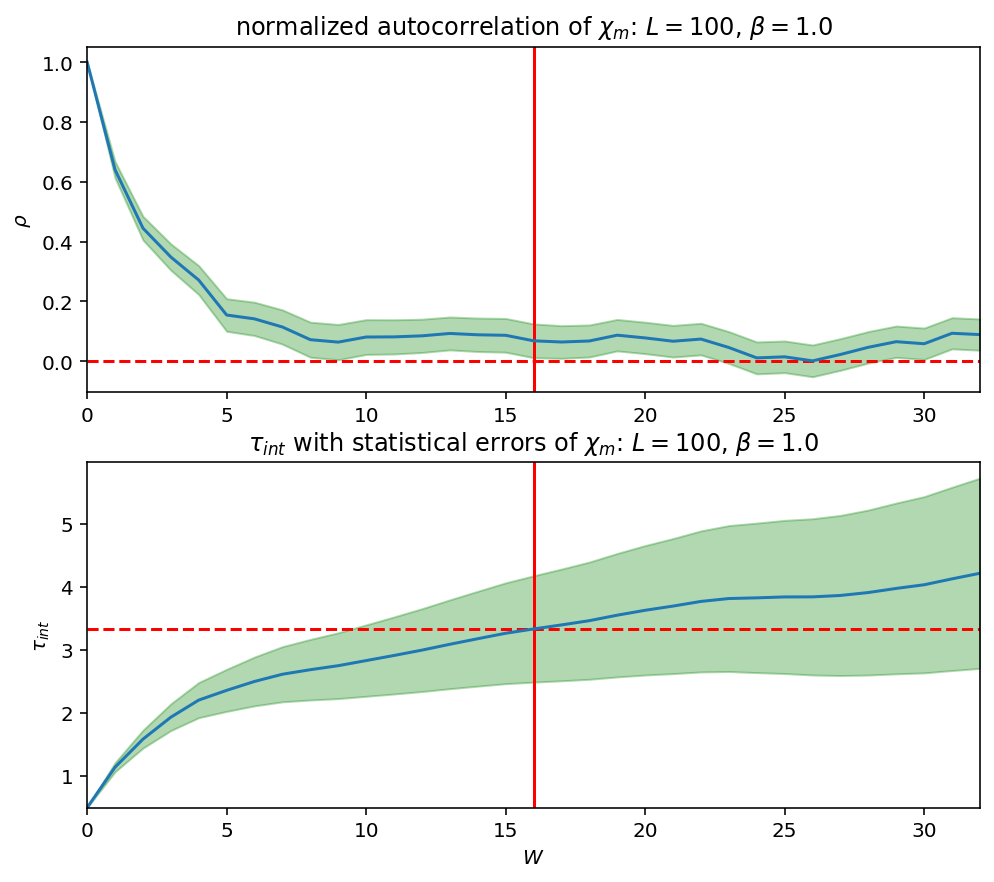

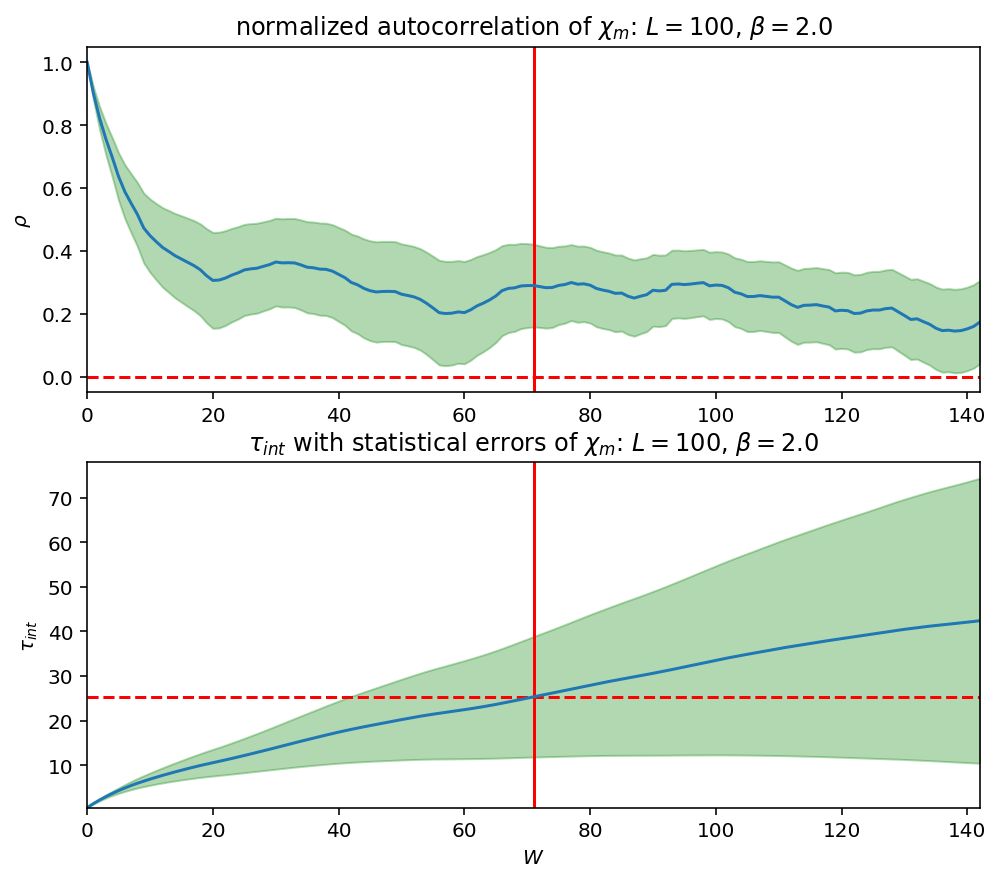

In [307]:

def plot_autocorrelation(beta):
    data = pd.read_csv(output_file)
    name = f"$\\chi_m$: $L={L}$, $\\beta={beta}$"
    series = data[(data['tau'] == 0.) & (data['beta'] == beta)]['chi_m'].to_numpy()
    UWerr(series, name=name, plot=True)

print_stats()
plot_autocorrelation(0.5)
plot_autocorrelation(1.0)
plot_autocorrelation(2.0)
